データサイエンス グループワーク第2週

実施したこと

- データの読み込み
- 特徴量の確認

**追記：プログラム作成にはGitHub Copilotを使用しています**

In [1]:
%matplotlib inline
# ライブラリのインポート
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import japanize_matplotlib
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

xgb.set_config(verbosity=0)

In [2]:
# 学習データの読み込み
train_data = pd.read_csv("train.csv") # ファイル名とパスは各自で変更してください
train_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [3]:
# テストデータの読み込み
test_data = pd.read_csv("test.csv") # ファイル名とパスは各自で変更してください
test_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [4]:
test_datetime = test_data["datetime"]

##### データの観察

データにおける各項目の意味は以下の通りです。

- datetime: 日時(1時間ごと)
- season: 
    1. 春
    2. 夏
    3. 秋
    4. 冬
- holiday: その日が休日とみなされているかどうか
- workingday: その日が週末でも休日でもないかどうか
- weather: 
    1. 晴れ、少量の雲、一部曇り、一部曇り
    2. 霧 曇り、霧 切れ間のある雲、霧 少量の雲、霧
    3. 小雪、小雨 雷雨 散在する雲、小雨 散在する雲
    4. 大雨 氷のパレット 雷雨 霧、雪 霧
- temp: 摂氏温度(℃)
- atemp: 体感温度
- humidity: 湿度
- windspeed: 風速
- casual: 開始された非登録ユーザーのレンタル数
- registerd: レンタルを開始した登録ユーザーの数
- count: 総レンタル数

In [5]:
train_data.sample(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
762,2011-02-15 04:00:00,1,0,1,1,9.02,9.090,37,35.0008,0,1,1
5943,2012-02-03 20:00:00,1,0,1,1,13.94,17.425,49,7.0015,8,155,163
1767,2011-04-19 13:00:00,2,0,1,2,22.14,25.760,68,15.0013,26,103,129
1842,2011-05-03 16:00:00,2,0,1,1,29.52,33.335,54,31.0009,46,225,271
1831,2011-05-03 05:00:00,2,0,1,1,21.32,25.000,88,8.9981,0,14,14


In [6]:
# "casual" と "registered" は予測対象のため、削除
train_data = train_data.drop(["casual", "registered"], axis=1)

In [7]:
# まとめて処理をするためにリストに格納
both_data = [train_data, test_data]

In [8]:
for dataset in both_data:
    # datetime型に変換して月，時間，曜日を取得(0:月曜, 1:火曜, ..., 6:日曜)
    dataset["datetime"] = pd.to_datetime(dataset["datetime"])
    dataset["month"] = dataset["datetime"].dt.month
    dataset["hour"] = dataset["datetime"].dt.hour
    dataset["dayofweek"] = dataset["datetime"].dt.dayofweek
    dataset.drop("datetime", axis=1, inplace=True)

    # 前日との差分を取る
    dataset["temp_lag_yesterday"] = dataset["temp"].shift(1)
    dataset["atemp_lag_yesterday"] = dataset["atemp"].shift(1)
    dataset["humidity_lag_yesterday"] = dataset["humidity"].shift(1)
    dataset["windspeed_lag_yesterday"] = dataset["windspeed"].shift(1)

/tmp/ipykernel_201024/165542432.py:4: FutureWarning: The provided callable <function sum at 0x7f1f30161750> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  rentals = train_data.pivot_table(values='count', index=column_name, aggfunc=np.sum).reset_index()
/tmp/ipykernel_201024/165542432.py:4: FutureWarning: The provided callable <function sum at 0x7f1f30161750> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  rentals = train_data.pivot_table(values='count', index=column_name, aggfunc=np.sum).reset_index()
/tmp/ipykernel_201024/165542432.py:4: FutureWarning: The provided callable <function sum at 0x7f1f30161750> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep curre

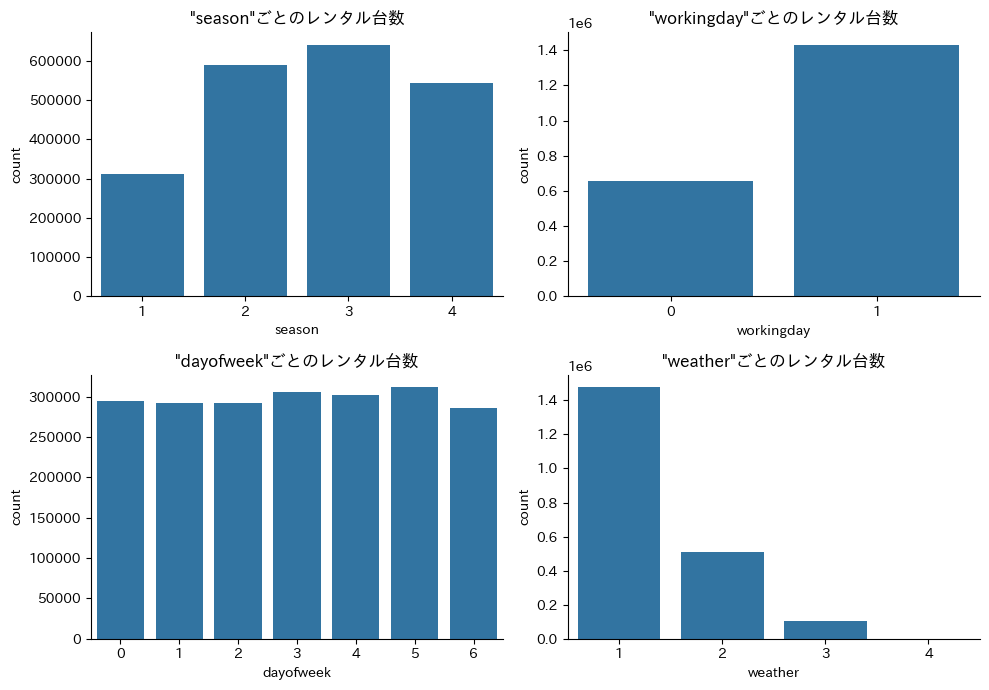

In [9]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 7))

for i, column_name in enumerate(['season', 'workingday', 'dayofweek', 'weather']):
    rentals = train_data.pivot_table(values='count', index=column_name, aggfunc=np.sum).reset_index()
    rentals['percentage'] = np.round(100 * rentals['count'] / np.sum(rentals['count']))

    row, col = divmod(i, 2)
    barplot = sns.barplot(data=rentals, x=column_name, y='count', ax=ax[row, col])

    ax[row, col].set_title(f"\"{column_name}\"ごとのレンタル台数")
    sns.despine()

plt.tight_layout()
plt.show()

**結果から示唆されること**
- 秋に最もレンタル台数が多く，春に少ない
- workingday(平日)のほうが台数が多い
    - 曜日ごとでみると，各曜日にそれほど大きな差はないため，平日:休日が5:2の割合となっている可能性が考えられる
- 晴れの場合が最も台数が多く，天気が悪くなるほど台数は減少傾向

##### 温度に関するデータを確認

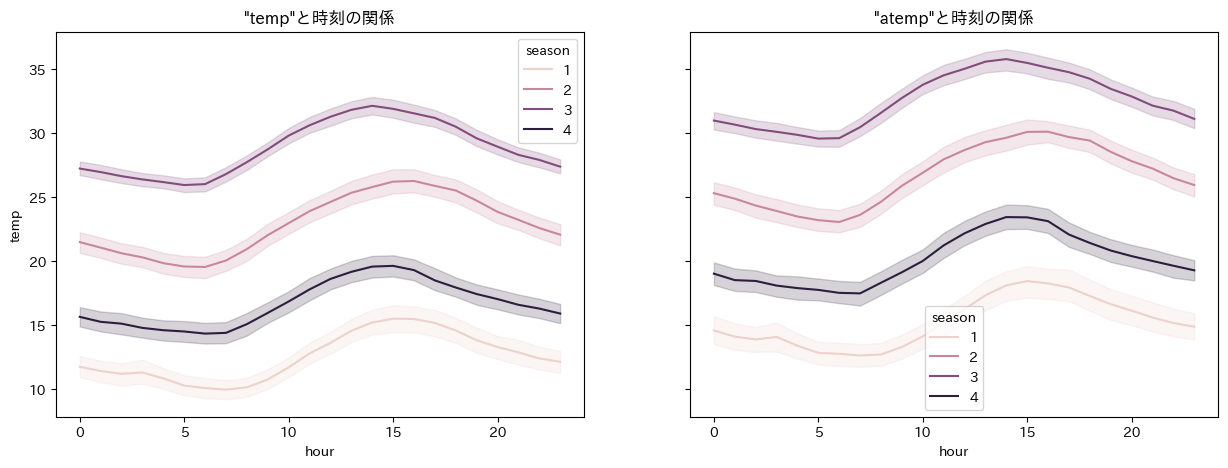

In [10]:
# 温度，体感温度と時刻の関係をグラフ化
fig, ax = plt.subplots(1, 2, sharey="row", figsize=(15, 5))
for i, column_name in enumerate(["temp", "atemp"]):
    sns.lineplot(data=train_data, x='hour', y=column_name, hue='season', ax=ax[i])
    ax[i].set_title(f"\"{column_name}\"と時刻の関係")
    ax[i].set_yticks(np.arange(10, 40, 5))
plt.show()


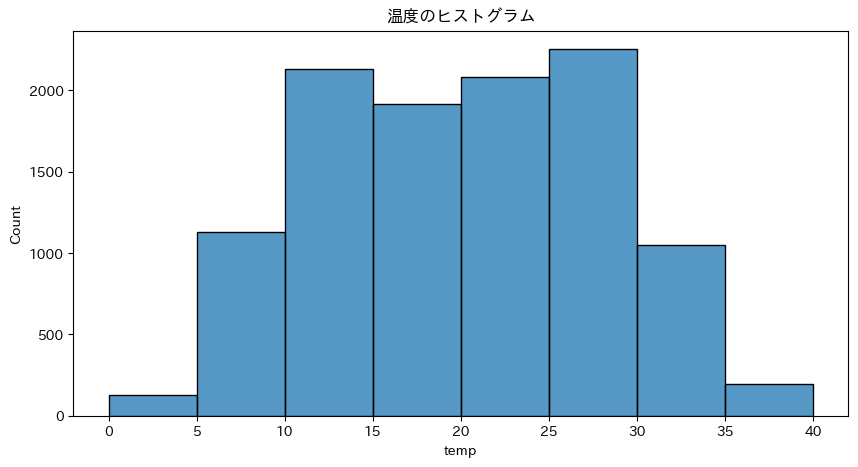

In [11]:
# ヒストグラムの表示
plt.figure(figsize=(10, 5))
sns.histplot(train_data["temp"], bins=range(0, 41, 5))
plt.title("温度のヒストグラム")
plt.show()

**ここからわかること**
- 体感温度は気温から数℃~5℃程度高くなる傾向がある
- 気温の推移はどの季節においても概ね同じであり，異なるのは温度のみ
- 温度のヒストグラムにおいて，10-15℃と25-30℃が高くなっているのは，夏と冬の気温の大部分がこの部分に属するため

**体感温度と気温の差に関する特徴量を作成**

体感温度と気温の差が高い場合は，天候が悪いケースが想定される

In [12]:
# 体感温度と気温の差に関する特徴量を作成
for dataset in both_data:
    dataset["temp_diff"] = dataset["temp"] - dataset["atemp"]

##### データの分布の確認

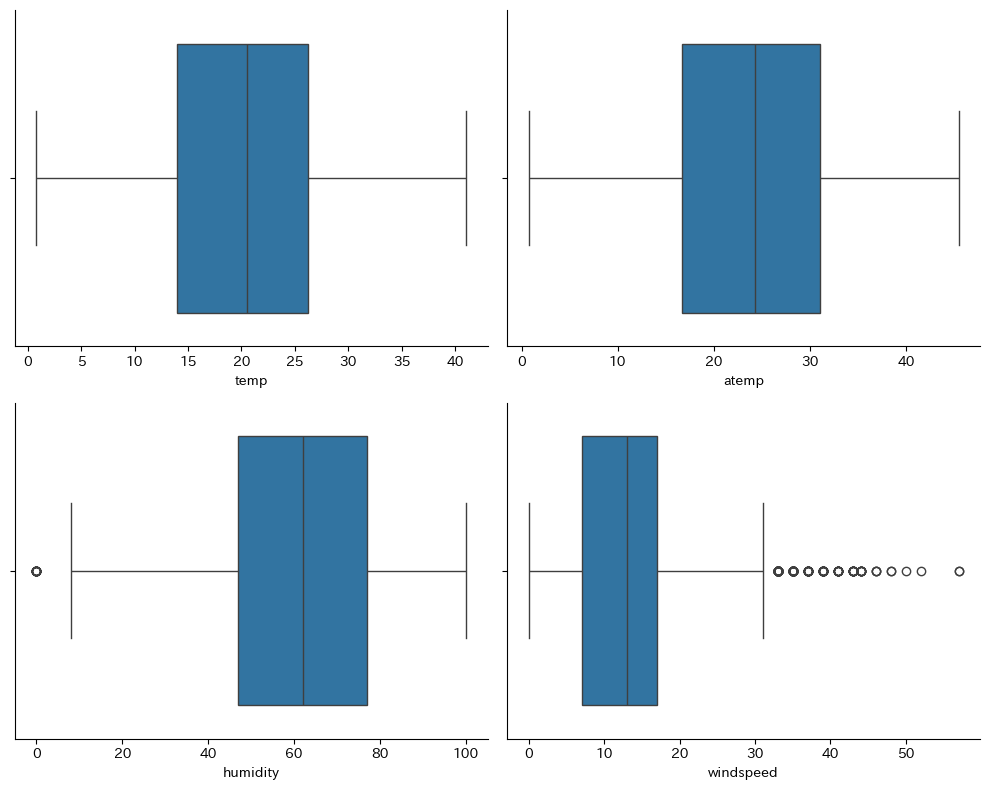

In [13]:
# データ分布を箱ひげ図で確認
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (10, 8))

for i, column in enumerate(['temp', 'atemp', 'humidity', 'windspeed']):

    row, col = divmod(i, 2)
    sns.boxplot(data = train_data, x = column, ax = ax[row, col])
    sns.despine()

plt.tight_layout()
plt.show()

**結果からわかること**
- "windspeed"には大量の外れ値がある

##### データの前処理

**外れ値を除外する**

箱ひげ図でも確認したが，他の変数についても再度確認する

In [14]:
train_data.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,month,hour,dayofweek,temp_lag_yesterday,atemp_lag_yesterday,humidity_lag_yesterday,windspeed_lag_yesterday,temp_diff
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10885.000000,10885.000000,10885.000000,10885.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,191.574132,6.521495,11.541613,3.013963,20.231513,23.655726,61.886082,12.799745,-3.424224
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,181.144454,3.444373,6.915838,2.004585,7.791650,8.474725,19.245877,8.164831,1.566612
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.820000,0.760000,0.000000,0.000000,-8.045000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,42.000000,4.000000,6.000000,1.000000,13.940000,16.665000,47.000000,7.001500,-4.055000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,145.000000,7.000000,12.000000,3.000000,20.500000,24.240000,62.000000,12.998000,-3.680000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,284.000000,10.000000,18.000000,5.000000,26.240000,31.060000,77.000000,16.997900,-2.745000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,977.000000,12.000000,23.000000,6.000000,41.000000,45.455000,100.000000,56.996900,23.140000


- 先ほど確認したとおり，"windspeed"は外れ値を持っている可能性が高い
- それ以外の変数については，外れ値となるような値はないものとして考える("count"はターゲットのため考えない)

In [15]:
# 外れ値を除外する関数
def remove_outliers_using_iqr(df, columns):
    df = df.copy()  # 元のデータフレームを変更しないようにコピーを作成

    for column in columns:
        q1 = df[column].quantile(0.25)
        q3 = df[column].quantile(0.75)
        iqr = q3 - q1
        outlier_min = q1 - 1.5 * iqr
        outlier_max = q3 + 1.5 * iqr
        df = df[(df[column] >= outlier_min) & (df[column] <= outlier_max)]

    return df

# "windspeed"，"casual"，"registered"について，外れ値を除外
outlier_columns = ["windspeed"]
train_data = remove_outliers_using_iqr(train_data, outlier_columns)

In [16]:
# 処理結果の確認
train_data.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,month,hour,dayofweek,temp_lag_yesterday,atemp_lag_yesterday,humidity_lag_yesterday,windspeed_lag_yesterday,temp_diff
count,10659.000000,10659.000000,10659.000000,10659.000000,10659.000000,10659.000000,10659.000000,10659.000000,10659.000000,10659.000000,10659.000000,10659.000000,10658.000000,10658.000000,10658.000000,10658.000000,10659.000000
mean,2.522000,0.028614,0.680645,1.417112,20.268901,23.713577,62.214373,12.292752,191.557838,6.569941,11.496200,3.019326,20.262725,23.702655,62.182867,12.435840,-3.444676
std,1.113455,0.166728,0.466248,0.631143,7.788440,8.443245,19.083557,7.441015,181.211409,3.435962,6.937627,2.003563,7.790095,8.451789,19.085178,7.747637,1.547331
min,1.000000,0.000000,0.000000,1.000000,0.820000,0.760000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.820000,0.760000,0.000000,0.000000,-8.045000
25%,2.000000,0.000000,0.000000,1.000000,13.940000,16.665000,47.000000,7.001500,42.000000,4.000000,6.000000,1.000000,13.940000,16.665000,47.000000,7.001500,-4.055000
50%,3.000000,0.000000,1.000000,1.000000,20.500000,24.240000,62.000000,11.001400,145.000000,7.000000,11.000000,3.000000,20.500000,24.240000,62.000000,11.001400,-3.680000
75%,4.000000,0.000000,1.000000,2.000000,26.240000,31.060000,78.000000,16.997900,285.000000,10.000000,18.000000,5.000000,26.240000,31.060000,78.000000,16.997900,-2.790000
max,4.000000,1.000000,1.000000,4.000000,41.000000,45.455000,100.000000,31.000900,977.000000,12.000000,23.000000,6.000000,41.000000,45.455000,100.000000,56.996900,23.140000


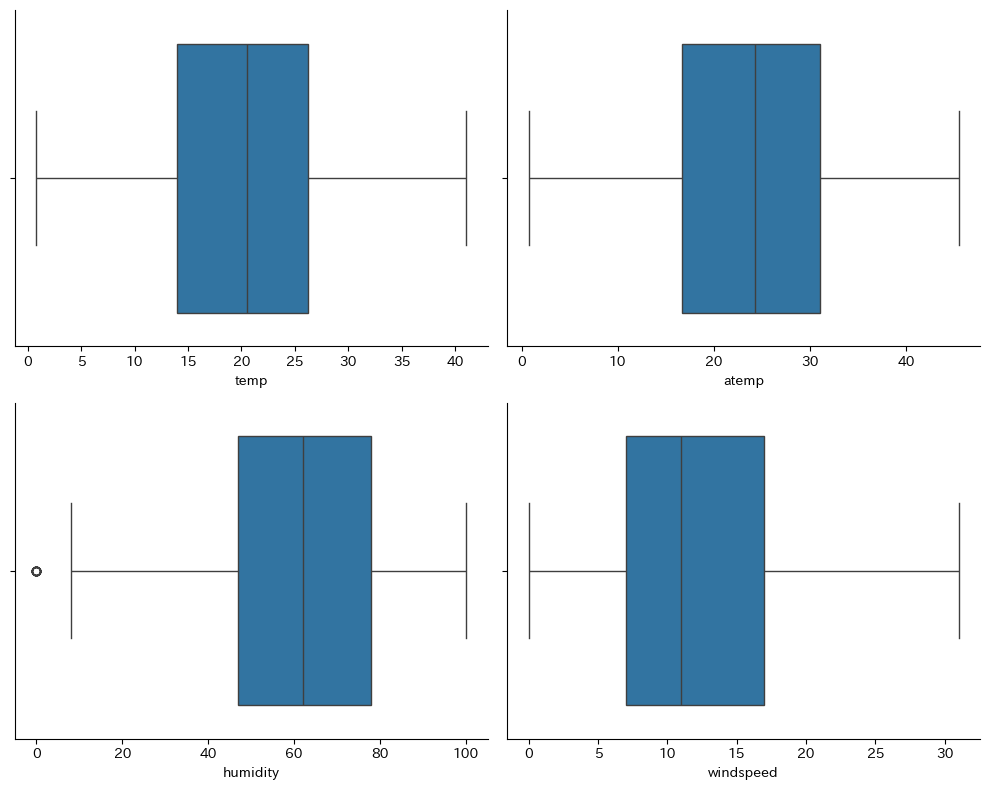

In [17]:
# データ分布を箱ひげ図で確認
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (10, 8))

for i, column in enumerate(['temp', 'atemp', 'humidity', 'windspeed']):

    row, col = divmod(i, 2)
    sns.boxplot(data = train_data, x = column, ax = ax[row, col])
    sns.despine()

plt.tight_layout()
plt.show()

**相関係数の確認**

<Axes: >

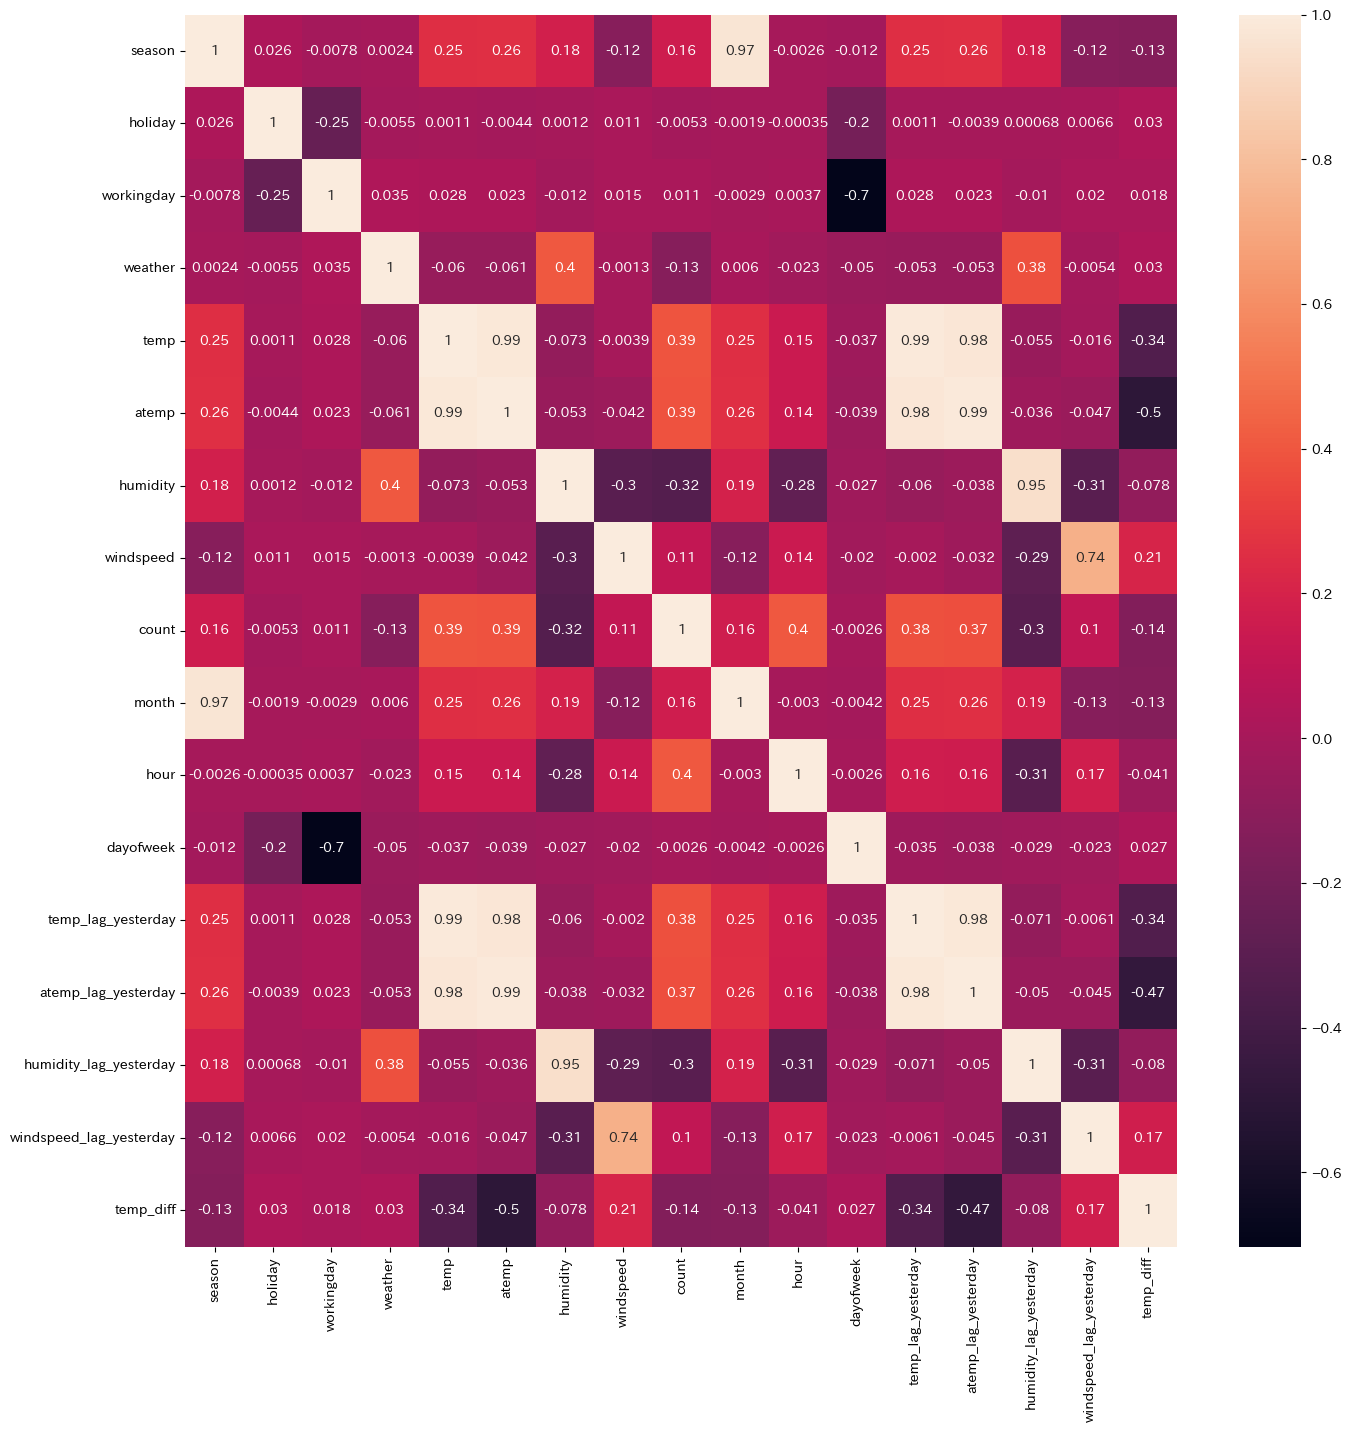

In [18]:
plt.figure(figsize = (16, 16))
sns.heatmap(train_data.corr(), annot = True) # ヒートマップの表示

##### 学習・推論

**データの準備**

In [19]:
# train_dataを学習・検証・テストデータに分割(8:2)
X = train_data.drop(["count"], axis=1)
y = train_data['count']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=0)

**学習**

In [20]:
# データをxgbのデータ構造に変換
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)

# ハイパーパラメータの設定
params = {'objective': 'reg:squarederror', 'silent': 1, 'random_state': 1234}
num_round = 50

# 学習
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
model = xgb.train(params, dtrain, num_round, evals=watchlist)

# 予測
pred = model.predict(dvalid)
mse = np.round(mean_squared_error(y_valid, pred), 2)
print(f'Mean Squared Error: {mse}')

r2_score = np.round(r2_score(y_valid, pred), 2)
print(f'R^2: {r2_score}')

[0]	train-rmse:144.99737	eval-rmse:153.18206
[1]	train-rmse:121.64595	eval-rmse:130.65379
[2]	train-rmse:107.84072	eval-rmse:117.32820
[3]	train-rmse:94.90640	eval-rmse:104.81824
[4]	train-rmse:86.93362	eval-rmse:96.54225
[5]	train-rmse:81.58129	eval-rmse:90.52519
[6]	train-rmse:75.75472	eval-rmse:83.84979
[7]	train-rmse:73.59424	eval-rmse:82.09529
[8]	train-rmse:71.27856	eval-rmse:79.99802
[9]	train-rmse:69.20590	eval-rmse:78.28962
[10]	train-rmse:66.63637	eval-rmse:75.13461
[11]	train-rmse:65.50678	eval-rmse:74.30181
[12]	train-rmse:64.74307	eval-rmse:73.96026
[13]	train-rmse:63.37835	eval-rmse:72.56749
[14]	train-rmse:62.99445	eval-rmse:72.45227
[15]	train-rmse:62.48883	eval-rmse:72.06964
[16]	train-rmse:62.19896	eval-rmse:71.95757
[17]	train-rmse:61.87144	eval-rmse:71.81990
[18]	train-rmse:60.72172	eval-rmse:71.03060
[19]	train-rmse:59.74219	eval-rmse:70.43760
[20]	train-rmse:58.99813	eval-rmse:70.36052
[21]	train-rmse:58.58455	eval-rmse:70.27801
[22]	train-rmse:58.03466	eval-rmse:

予測値に対して，R^2スコアが0.88となった．

##### 提出用データの作成

In [21]:
X_test = test_data

# データをxgbのデータ構造に変換
dtest = xgb.DMatrix(X_test)
test_pred = model.predict(dtest)

In [22]:
csv_submission = pd.DataFrame({
    'datetime': test_datetime,
    'count': test_pred
})

csv_submission["count"].where(csv_submission["count"] > 0, 0, inplace=True)

csv_submission.to_csv('submission.csv', index=False)

/tmp/ipykernel_201024/2149270801.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  csv_submission["count"].where(csv_submission["count"] > 0, 0, inplace=True)
